In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

In [30]:
def load_file(file):
    df=pd.read_csv(file, sep="|", names=['loan_seq_nbr',
                                            'mnth_rep_dt',
                                                                        'curr_upb',
                                                                        'loan_delq_stat',
                                                                        'loan_age',
                                                                        'rem_month',
                                                                        'repurch_flg',
                                                                        'modn_flg',
                                                                        'zero_bal_cd',
                                                                        'zero_bal_efftv_dt',
                                                                        'curr_int_rate',
                                                                        'curr_deff_upb',
                                                                        'due_dt_lpi',
                                                                        'mi_recv',
                                                                        'net_sales',
                                                                        'non_mi_recv',
                                                                        'expens',
                                                                        'legal_cost',
                                                                        'preserv_cost',
                                                                        'taxes',
                                                                        'misc_expens',
                                                                        'actual_loss',
                                                                        'modn_cost',
                                                                        'stp_modn_flg',
                                                                        'def_pay_modn',
                                                                        'est_loan_to_val'], nrows=1000000)
    return df
    

In [32]:
df=load_file('historical_data1_time_Q11999.txt')

/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [33]:
def frame_transform(frame):
    frame['loan_delq_stat'] = [ 0 if x=='XX' else x for x in (frame['loan_delq_stat'].apply(lambda x: x))]
    frame['loan_delq_stat'] = [ 999 if x=='R' else x for x in (frame['loan_delq_stat'].apply(lambda x: x))]
    frame['modn_flg'] = [ 0 if x=='N' else 1 for x in (frame['modn_flg'].apply(lambda x: x))]
    frame[['net_sales']] = [ 0 if x=='U' else x for x in (frame['net_sales'].apply(lambda x: x))]
    frame[['net_sales']] = [ 999 if x=='C' else x for x in (frame['net_sales'].apply(lambda x: x))]
    frame[['def_pay_modn']] = [ 'Z' if x==' ' else x for x in (frame['def_pay_modn'].apply(lambda x: x))]
    # frame[['net_sales']] = [ frame['curr_deff_upb'] if x=='C' else x for x in (frame['net_sales'].apply(lambda x: x)]
    # frame[['net_sales']] = [ frame['curr_deff_upb'] if x=='C' else x for x in (frame['net_sales'].apply(lambda x: x)) ]
    return frame
                                      

In [34]:
def handle_missing(frame):
    frame['loan_delq_stat']=frame['loan_delq_stat'].fillna(0)
    frame['repurch_flg']=frame['repurch_flg'].fillna('Z')
    frame['modn_flg']=frame['modn_flg'].fillna('N')
    frame['stp_modn_flg']=frame['stp_modn_flg'].fillna('Z')
    frame['zero_bal_cd']=frame['zero_bal_cd'].fillna(0)
    frame['curr_deff_upb']=frame['curr_deff_upb'].fillna(0)
    frame['mi_recv']=frame['mi_recv'].fillna(0)
    frame['net_sales']=frame['net_sales'].fillna(0)
    frame['non_mi_recv']=frame['non_mi_recv'].fillna(0)
    frame['expens']=frame['expens'].fillna(0)
    frame['legal_cost']=frame['legal_cost'].fillna(0)
    frame['preserv_cost']=frame['preserv_cost'].fillna(0)
    frame['misc_expens']=frame['misc_expens'].fillna(0)
    frame['actual_loss']=frame['actual_loss'].fillna(0)
    frame['modn_cost']=frame['modn_cost'].fillna(0)
    # df['zero_bal_efftv_dt']=df['zero_bal_efftv_dt'].fillna(0)
    # df['due_dt_lpi']=df['due_dt_lpi'].fillna(0)
    # df['taxes']=df['taxes'].fillna(0)
    # df['est_loan_to_val']=df['est_loan_to_val'].fillna(0)
    return frame

In [35]:
def handle_dtypes(frame):
    frame[['loan_seq_nbr','repurch_flg','modn_flg','stp_modn_flg','def_pay_modn']] = frame[['loan_seq_nbr','repurch_flg','modn_flg','stp_modn_flg','def_pay_modn']].astype(str)
    frame[['curr_upb','curr_int_rate','mi_recv','non_mi_recv','expens','legal_cost','preserv_cost','taxes','misc_expens','actual_loss','modn_cost','est_loan_to_val']] = frame[['curr_upb','curr_int_rate','mi_recv','non_mi_recv','expens','legal_cost','preserv_cost','taxes','misc_expens','actual_loss','modn_cost','est_loan_to_val']].astype(float)
    frame[['loan_age','rem_month','zero_bal_cd','curr_deff_upb','loan_delq_stat']] = frame[['loan_age','rem_month','zero_bal_cd','curr_deff_upb','loan_delq_stat']].astype(int)
    return frame

In [36]:
def feature_engg(frame):
    frame['delinquency'] = (frame.loan_delq_stat > 0).astype(int)
    frame = frame.drop('loan_delq_stat', axis = 1)
    return frame

In [37]:
def feature_encode(frame):
    
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    le = LabelEncoder()

    frame['repurch_flg'] = le.fit_transform(frame['repurch_flg'])
    frame['stp_modn_flg'] = le.fit_transform(frame['stp_modn_flg'])
    frame['def_pay_modn'] = le.fit_transform(frame['def_pay_modn'])

    onehotencoder = OneHotEncoder()

    frame_repurch_flg = onehotencoder.fit_transform(frame.repurch_flg.values.reshape(-1,1)).toarray()
    frame_stp_modn_flg=onehotencoder.fit_transform(frame.stp_modn_flg.values.reshape(-1,1)).toarray()
    frame_def_pay_modn=onehotencoder.fit_transform(frame.def_pay_modn.values.reshape(-1,1)).toarray()

    repurch_flg_onehot = pd.DataFrame(frame_repurch_flg, columns = ["repurch_flg_"+str(int(i)) for i in range(frame_repurch_flg.shape[1])])
    frame = pd.concat([frame, repurch_flg_onehot], axis=1)

    stp_modn_flg_onehot = pd.DataFrame(frame_stp_modn_flg, columns = ["stp_modn_flg_"+str(int(i)) for i in range(frame_stp_modn_flg.shape[1])])
    frame = pd.concat([frame, stp_modn_flg_onehot], axis=1)

    def_pay_modn_onehot = pd.DataFrame(frame_def_pay_modn, columns = ["def_pay_modn"+str(int(i)) for i in range(frame_def_pay_modn.shape[1])])
    frame = pd.concat([frame, def_pay_modn_onehot], axis=1)

    frame.drop(['repurch_flg', 'stp_modn_flg','def_pay_modn'], axis=1)
    return frame
    

In [38]:
def feature_encode_feature_select(frame):
    
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    le = LabelEncoder()

    #frame['repurch_flg'] = le.fit_transform(frame['repurch_flg'])
    frame['stp_modn_flg'] = le.fit_transform(frame['stp_modn_flg'])
    frame['def_pay_modn'] = le.fit_transform(frame['def_pay_modn'])

    onehotencoder = OneHotEncoder()

    #frame_repurch_flg = onehotencoder.fit_transform(frame.repurch_flg.values.reshape(-1,1)).toarray()
    frame_stp_modn_flg=onehotencoder.fit_transform(frame.stp_modn_flg.values.reshape(-1,1)).toarray()
    frame_def_pay_modn=onehotencoder.fit_transform(frame.def_pay_modn.values.reshape(-1,1)).toarray()

    #repurch_flg_onehot = pd.DataFrame(frame_repurch_flg, columns = ["repurch_flg_"+str(int(i)) for i in range(frame_repurch_flg.shape[1])])
    #frame = pd.concat([frame, repurch_flg_onehot], axis=1)

    stp_modn_flg_onehot = pd.DataFrame(frame_stp_modn_flg, columns = ["stp_modn_flg_"+str(int(i)) for i in range(frame_stp_modn_flg.shape[1])])
    frame = pd.concat([frame, stp_modn_flg_onehot], axis=1)

    def_pay_modn_onehot = pd.DataFrame(frame_def_pay_modn, columns = ["def_pay_modn"+str(int(i)) for i in range(frame_def_pay_modn.shape[1])])
    frame = pd.concat([frame, def_pay_modn_onehot], axis=1)

    frame.drop(['stp_modn_flg','def_pay_modn'], axis=1)
    return frame
    

In [39]:
def scale_minmax(X):
    
    from sklearn.preprocessing import MinMaxScaler

    mm_scale_X = MinMaxScaler()

    X = mm_scale_X.fit_transform(X)

    return X

In [40]:
def create_X(frame):
    frame=frame.drop(['loan_seq_nbr','delinquency'], axis=1)
    
    # Removing these columns temporarily
    frame = frame.drop('zero_bal_efftv_dt', axis = 1)
    frame = frame.drop('due_dt_lpi', axis = 1)
    frame = frame.drop('taxes', axis = 1)
    frame = frame.drop('est_loan_to_val', axis = 1)
    
    return frame

In [41]:
def create_X_feature_select(frame,columns):
    frame=frame.drop(['loan_seq_nbr','delinquency'], axis=1)
    
    # Removing these columns temporarily
    frame = frame.drop('zero_bal_efftv_dt', axis = 1)
    frame = frame.drop('due_dt_lpi', axis = 1)
    frame = frame.drop('taxes', axis = 1)
    frame = frame.drop('est_loan_to_val', axis = 1)
    
    frame=frame[columns]
    return frame

In [42]:
def create_y(frame):
    
    frame=frame[['delinquency']]
    return frame

In [43]:
def model_metrics(model,x_training,x_testing,y_training,y_testing,y_predict,y_predict_train):

    print("Training and Testing accuracy:")
    print("\n")
    print('Random Forest Regrssion  - Score - Training: %.4f' % model.score(x_training, y_training))
    print('Random Forest Regression - Score - Testing: %.4f' % model.score(x_testing, y_testing))
    
    from sklearn import metrics

    print("Confusion Matrix:")
    print("\n")
    
    
    cm_train = metrics.confusion_matrix(y_training, y_predict_train)
    print(cm_train)
    print("\n")
    print("Confusion matrix accuracy (train): " + str((cm_train[0,0]+cm_train[1,1])/np.sum(cm_train)))
    
    print("\n")

    cm_test = metrics.confusion_matrix(y_testing, y_predict)
    print(cm_test)
    print("\n")
    print("Confusion matrix accuracy (test): " + str((cm_test[0,0]+cm_test[1,1])/np.sum(cm_test)))
    
    print("\n")
    
    
    
    print("Confusion Matrix:")
    print("\n")
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm_train), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix - Train', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm_test), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix - Test', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print("ROC Graph:")
    print("\n")
    
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_curve
    logit_roc_auc = roc_auc_score(y_testing, model.predict(x_testing))
    fpr, tpr, thresholds = roc_curve(y_testing, model.predict_proba(x_testing)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    # print("Model Co-efficients:" + str(model.coef_))
    
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return cm_test




In [44]:
def gen_metric_file(y_frame_test,c_matrix,quarter):
    
    import os
    
    quart = quarter
    
    cols = ["Quarter",
         "Total num of actual deliquent",
         "Total num of predicted deliquent",
         "Total num of records",
         "Total num of deliquent prop classd",
         "Total num of deliquent improp classd"]

    total_num_act_delq = np.count_nonzero(y_frame_test==1)
    total_num_pred_delq = (c_matrix[1][0] + c_matrix[1][1])
    total_num_records = len(y_frame_test)
    total_num_delq_class_prop = (c_matrix[1][1])
    total_num_delq_class_improp = (c_matrix[1][0])
    
    frame_file = pd.DataFrame(columns=cols)
    
    frame_temp = pd.DataFrame([[quart, 
                       total_num_act_delq, 
                       total_num_pred_delq, 
                       total_num_records, 
                       total_num_delq_class_prop, 
                       total_num_delq_class_improp]], columns=cols)

    frame_file = frame_file.append(frame_temp)
    
    filenm = "metric_file.csv"
    
    writeHeader = True
    
    if os.path.exists(filenm):
        writeHeader = False
    
    if writeHeader is False:
        with open(filenm, 'a',encoding = 'utf-8', newline="") as f:
            df.to_csv(f, mode='a', header = False,index = False)
    else:
        with open(filenm, 'w',encoding = 'utf-8', newline="") as f:
            df.to_csv(f, mode='a', header = True,index = False)


# gen_metric_file(y_test,cm,'1999')

In [45]:
train=load_file('historical_data1_time_Q11999.txt')
train=handle_missing(train)
train=frame_transform(train)
train=handle_dtypes(train)
train=feature_engg(train)


X_train=create_X(train)
y_train=create_y(train)
X_train=feature_encode(X_train)
X_train=scale_minmax(X_train)
y_train=scale_minmax(y_train)



/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
model=lr.fit(X_train,y_train)

/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
score = model.score(X_train, y_train)
print(score)

0.972576


In [48]:


test=load_file('historical_data1_time_Q21999.txt')
test=handle_missing(test)
test=frame_transform(test)
test=handle_dtypes(test)
test=feature_engg(test)


X_test=create_X(test)
y_test=create_y(test)
X_test=feature_encode(X_test)
X_test=scale_minmax(X_test)
y_test=scale_minmax(y_test)





/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (3,7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in versi

In [49]:
y_pred=model.predict(X_test)

In [50]:
# For Train CM

y_pred_train=model.predict(X_train)

Training and Testing accuracy:


Random Forest Regrssion  - Score - Training: 0.9726
Random Forest Regression - Score - Testing: 0.9692
Confusion Matrix:


[[972115    253]
 [ 27171    461]]


Confusion matrix accuracy (train): 0.972576


[[968716    483]
 [ 30299    502]]


Confusion matrix accuracy (test): 0.969218


Confusion Matrix:


ROC Graph:




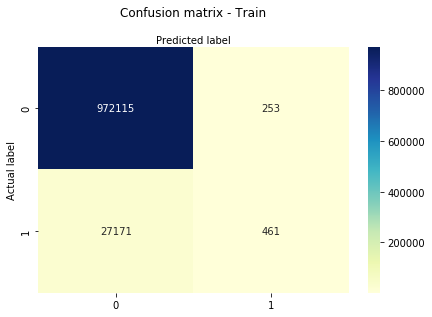

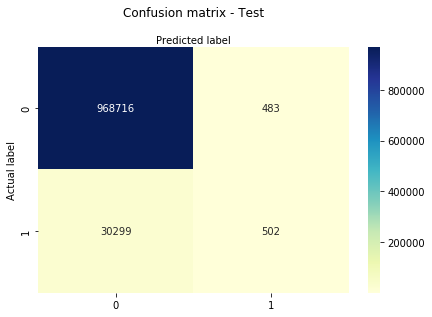

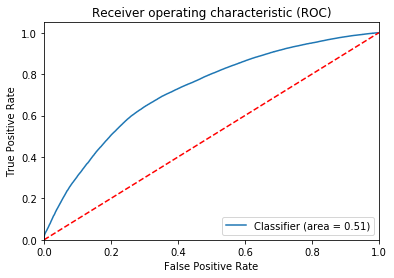

Accuracy: 0.969218


In [51]:
cm=model_metrics(model,X_train,X_test,y_train,y_test,y_pred,y_pred_train)


In [52]:
# Feature Selection

from sklearn.feature_selection import RFE
rfe = RFE(model, 12)
rfe = rfe.fit(X_train, y_train.ravel())
# print summaries for the selection of attributes
print("Number of features: " + str(rfe.n_features_))
print(rfe.support_)
print("Selected Features: " + str(rfe.ranking_))


/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Defau

Number of features: 12
[ True False  True  True False False  True  True False  True  True  True
  True False False False  True False False False False False False False
 False  True False False  True]
Selected Features: [ 1 15  1  1 16  2  1  1 17  1  1  1  1  3  8  9  1 10  5  4 13 14  6 12 11
  1  7 18  1]


In [53]:
selected_columns=['mnth_rep_dt',
                  'loan_age','rem_month',
                  'zero_bal_cd',
                  'curr_int_rate',
                  'mi_recv','net_sales','non_mi_recv',
                  'expens','actual_loss','stp_modn_flg','def_pay_modn']

In [54]:
# Feature Selection

from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier

# Create a Classifier
clf=RandomForestClassifier(n_estimators=10, random_state=2)


rfe = RFE(clf, 12)
rfe = rfe.fit(X_train, y_train.ravel())
# print summaries for the selection of attributes
print("Number of features: " + str(rfe.n_features_))
print(rfe.support_)
print("Selected Features: " + str(rfe.ranking_))

Number of features: 12
[ True  True  True  True False  True  True  True False False  True False
  True False False False False False  True False False False False  True
 False False False False  True]
Selected Features: [ 1  1  1  1  2  1  1  1  3 14  1  5  1 17 18 12  9  6  1 15  7 11 10  1 13
  4  8 16  1]


In [56]:
train=load_file('historical_data1_time_Q11999.txt')
train=handle_missing(train)
train=frame_transform(train)
train=handle_dtypes(train)
train=feature_engg(train)


X_train=create_X_feature_select(train,selected_columns)
y_train=create_y(train)
X_train=feature_encode_feature_select(X_train)
X_train=scale_minmax(X_train)
y_train=scale_minmax(y_train)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
fit=model.fit(X_train,y_train)

score = fit.score(X_train, y_train)
print(score)

test=load_file('historical_data1_time_Q21999.txt')
test=handle_missing(test)
test=frame_transform(test)
test=handle_dtypes(test)
test=feature_engg(test)


X_test=create_X_feature_select(test,selected_columns)
y_test=create_y(test)
X_test=feature_encode_feature_select(X_test)
X_test=scale_minmax(X_test)
y_test=scale_minmax(y_test)


y_pred=model.predict(X_test)


/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version

0.972534


/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (3,7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in versi

In [62]:
y_pred_train=model.predict(X_train)

Training and Testing accuracy:


Random Forest Regrssion  - Score - Training: 0.9725
Random Forest Regression - Score - Testing: 0.9694
Confusion Matrix:


[[972138    230]
 [ 27236    396]]


Confusion matrix accuracy (train): 0.972534


[[921037  48162]
 [ 27271   3530]]


Confusion matrix accuracy (test): 0.924567


Confusion Matrix:


ROC Graph:




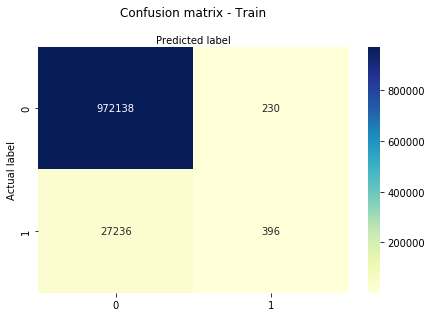

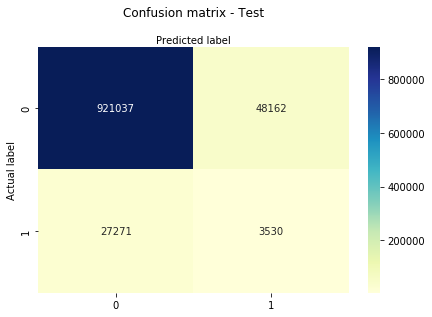

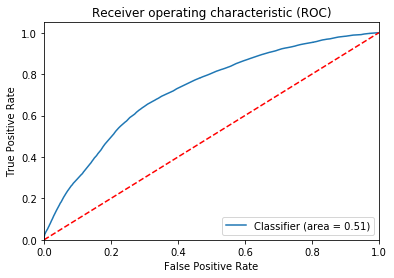

Accuracy: 0.924567


In [63]:
cm=model_metrics(model,X_train,X_test,y_train,y_test,y_pred,y_pred_train)


In [57]:
selected_columns=['mnth_rep_dt',
                  'loan_age','rem_month',
                  'zero_bal_cd',
                  'curr_int_rate',
                  'mi_recv','net_sales','non_mi_recv',
                  'expens','actual_loss','stp_modn_flg','def_pay_modn']

In [61]:
# Random Forest Classifier

train=load_file('historical_data1_time_Q11999.txt')
train=handle_missing(train)
train=frame_transform(train)
train=handle_dtypes(train)
train=feature_engg(train)


X_train=create_X_feature_select(train,selected_columns)
y_train=create_y(train)
X_train=feature_encode_feature_select(X_train)
X_train=scale_minmax(X_train)
y_train=scale_minmax(y_train)

# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Classifier
clf=RandomForestClassifier(n_estimators=70, random_state=2)

# Train the model using the training sets
model_rf=clf.fit(X_train,y_train)

score = model_rf.score(X_train, y_train)
print(score)

test=load_file('historical_data1_time_Q21999.txt')
test=handle_missing(test)
test=frame_transform(test)
test=handle_dtypes(test)
test=feature_engg(test)


X_test=create_X_feature_select(test,selected_columns)
y_test=create_y(test)
X_test=feature_encode_feature_select(X_test)
X_test=scale_minmax(X_test)
y_test=scale_minmax(y_test)


y_pred=model_rf.predict(X_test)





/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version

0.974697


/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (3,7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in versi

In [64]:
y_pred_train=model.predict(X_train)

Training and Testing accuracy:


Random Forest Regrssion  - Score - Training: 0.9747
Random Forest Regression - Score - Testing: 0.9246
Confusion Matrix:


[[972138    230]
 [ 27236    396]]


Confusion matrix accuracy (train): 0.972534


[[921037  48162]
 [ 27271   3530]]


Confusion matrix accuracy (test): 0.924567


Confusion Matrix:


ROC Graph:




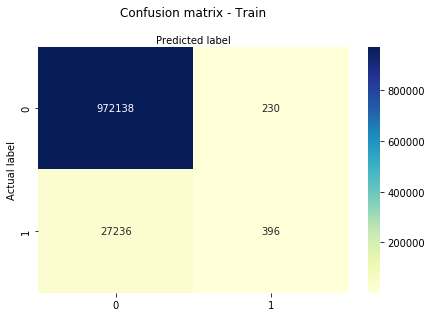

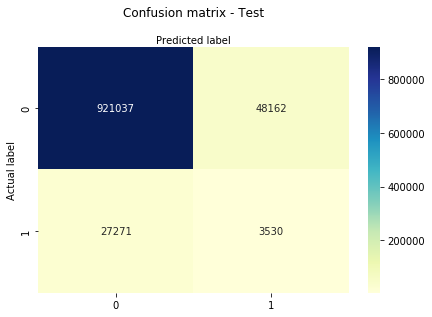

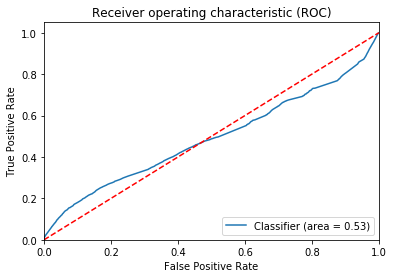

Accuracy: 0.924567


array([[921037,  48162],
       [ 27271,   3530]])

In [65]:
model_metrics(model_rf,X_train,X_test,y_train,y_test,y_pred, y_pred_train)


In [60]:
# Hyper Parameter Tuning on Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection
from sklearn.ensemble import RandomForestClassifier

param_grid1 = {'n_estimators' : [30, 50, 70],'random_state' : [0, 2]}
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid=param_grid1, cv = 3, n_jobs = -1, verbose=3, refit=True)
gs.fit(X_train, y_train)
gs.best_params_



Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 12.2min finished
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 12.2min remaining:    0.0s
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 70, 'random_state': 2}

In [68]:
# Neural Network


selected_columns=['mnth_rep_dt',
                  'loan_age','rem_month',
                  'zero_bal_cd',
                  'curr_int_rate',
                  'mi_recv','net_sales','non_mi_recv',
                  'expens','actual_loss','stp_modn_flg','def_pay_modn']


train=load_file('historical_data1_time_Q11999.txt')
train=handle_missing(train)
train=frame_transform(train)
train=handle_dtypes(train)
train=feature_engg(train)


X_train=create_X_feature_select(train,selected_columns)
y_train=create_y(train)
X_train=feature_encode_feature_select(X_train)
X_train=scale_minmax(X_train)
y_train=scale_minmax(y_train)

# Import MLP Neural Classifier
from sklearn.neural_network import MLPClassifier

# Create a Classifier
clf=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(30,30,10), random_state=1)

# Train the model using the training sets
model_neu=clf.fit(X_train,y_train)

score = model_neu.score(X_train, y_train)
print(score)

test=load_file('historical_data1_time_Q21999.txt')
test=handle_missing(test)
test=frame_transform(test)
test=handle_dtypes(test)
test=feature_engg(test)


X_test=create_X_feature_select(test,selected_columns)
y_test=create_y(test)
X_test=feature_encode_feature_select(X_test)
X_test=scale_minmax(X_test)
y_test=scale_minmax(y_test)


y_pred=model_neu.predict(X_test)






/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version

0.972501


/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (3,7,14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in versi

In [66]:
y_pred_train=model.predict(X_train)

In [67]:
model_metrics(model_neu,X_train,X_test,y_train,y_test,y_pred,y_pred_train)



NameError: name 'model_neu' is not defined

In [25]:
# TPOT Auto-ML

from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5,verbosity=2)

# train=load_file('historical_data1_time_Q11999.txt')

In [29]:
train['delinquency'].unique()


array([0, 1])

In [34]:
#train['loan_delq_stat'] = [ 0 if x=='XX' else x for x in (train['loan_delq_stat'].apply(lambda x: x))]
#train['loan_delq_stat'] = [ 999 if x=='R' else x for x in (train['loan_delq_stat'].apply(lambda x: x))]
#train['loan_delq_stat']=train['loan_delq_stat'].fillna(0)
#train.fillna(0, inplace=True)
#train[['loan_delq_stat']]=train[['loan_delq_stat']].astype(int)


#train['delinquency'] = (train.loan_delq_stat > 0).astype(int)

y_train_auto=train['delinquency']

X_train_auto=train.drop('delinquency', axis = 1)

y_train_auto=y_train_auto.astype(np.float64)


In [35]:
#tpot = TPOTClassifier(verbosity=2, max_time_mins=5, max_eval_time_mins=0.04, population_size=7)

#tpot.fit(X_train, y_train)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
tpot.fit(X_train, y_train)

/Users/srikantswamy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


A Jupyter Widget

In [42]:
type(X_train)

numpy.ndarray

In [44]:
np.isnan(X_train).any()

False